# Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
games = pd.read_csv("../../bgg_data/games.csv")
mechanics = pd.read_csv("../../bgg_data/mechanics.csv")
themes = pd.read_csv("../../bgg_data/themes.csv")
subcategories = pd.read_csv("../../bgg_data/subcategories.csv")
designers = pd.read_csv("../../bgg_data/designers_reduced.csv")
publishers = pd.read_csv("../../bgg_data/publishers_reduced.csv")
ratings_dist = pd.read_csv("../../bgg_data/ratings_distribution.csv")
user_ratings = pd.read_csv("../../bgg_data/user_ratings.csv")
embeddings_df = pd.read_csv("../../bgg_data/game_desc_embds.csv")

df = games.copy()
for aux_df in [mechanics, themes, subcategories, designers, publishers, ratings_dist]:
    df = pd.merge(df, aux_df, on="BGGId", how="left")
    
# compute normalized rating proportions to capture the full rating distribution.
rating_cols = [col for col in ratings_dist.columns if col not in ["BGGId", "total_ratings"]]
for col in rating_cols:
    ratings_dist[f"prop_{col}"] = ratings_dist[col] / ratings_dist["total_ratings"]

# create a DataFrame with just the normalized proportions
ratings_norm = ratings_dist[["BGGId"] + [f"prop_{col}" for col in rating_cols]]
df = pd.merge(ratings_norm, df, on="BGGId", how="left")

# for user_ratings, aggregate ratings per game (mean and count)
user_ratings_agg = (
    user_ratings.groupby("BGGId")
    .agg(user_rating_mean=("Rating", "mean"), user_rating_count=("Rating", "count"))
    .reset_index()
)
df = pd.merge(user_ratings_agg, df, on="BGGId", how="left")


In [3]:
games["Description"].head(5)

0    die macher game seven sequential political rac...
1    dragonmaster tricktaking card game base old ga...
2    samurai set medieval japan player compete gain...
3    triangular box luxurious large block tal der k...
4    acquire player strategically invest business t...
Name: Description, dtype: object

In [4]:
import json
with open('../../bgg_data/columns.json', 'w') as f:
    json.dump(column_dict, f)

In [6]:
game_desc = games[["BGGId", "Description"]]
game_desc.to_csv('../../bgg_data/game_descriptions.csv', index=False)

In [3]:
print("There are", len(df), "games.")

There are 21925 games.


# Data Cleaning and Summary Stats

In [4]:
print("Missing values per column:")
for col in df.columns:
    nas = df[col].isna().sum()
    if nas > 0:
        print(col, "\t\t", nas)

Missing values per column:
Description 		 1
ComAgeRec 		 5530
LanguageEase 		 5891
Family 		 15262
ImagePath 		 17


In [5]:
df = df.drop('Family', axis=1)
df = df.drop('ImagePath', axis=1)
df.dropna(subset=['Description'], inplace=True)
df = df.fillna(df.median())

/var/folders/hd/6z2wjwxj7qg9h_22989lv6d40000gn/T/ipykernel_46347/1230453120.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.median())


In [6]:
print("Missing values per column:")
for col in df.columns:
    nas = df[col].isna().sum()
    if nas > 0:
        print(col, "\t\t", nas)

Missing values per column:


In [7]:
print("\nSummary statistics for numeric features:")
print(df.describe())


Summary statistics for numeric features:
               BGGId  user_rating_mean  user_rating_count      prop_0.0  \
count   21924.000000      21924.000000       21924.000000  2.192400e+04   
mean   117650.230660          6.432151         863.991607  6.545577e-07   
std    104630.488022          0.939258        3627.162554  6.825248e-05   
min         1.000000          1.041333           7.000000  0.000000e+00   
25%     12342.750000          5.837731          57.000000  0.000000e+00   
50%    105292.500000          6.456024         125.000000  0.000000e+00   
75%    206170.500000          7.061786         398.000000  0.000000e+00   
max    349161.000000          9.732200      107760.000000  8.000000e-03   

           prop_0.1      prop_0.5      prop_1.0      prop_1.1      prop_1.2  \
count  2.192400e+04  2.192400e+04  21924.000000  21924.000000  21924.000000   
mean   4.165655e-08  7.527274e-07      0.010822      0.000054      0.000039   
std    4.640670e-06  8.898054e-05      0.0336

# Distributions of Key Columns

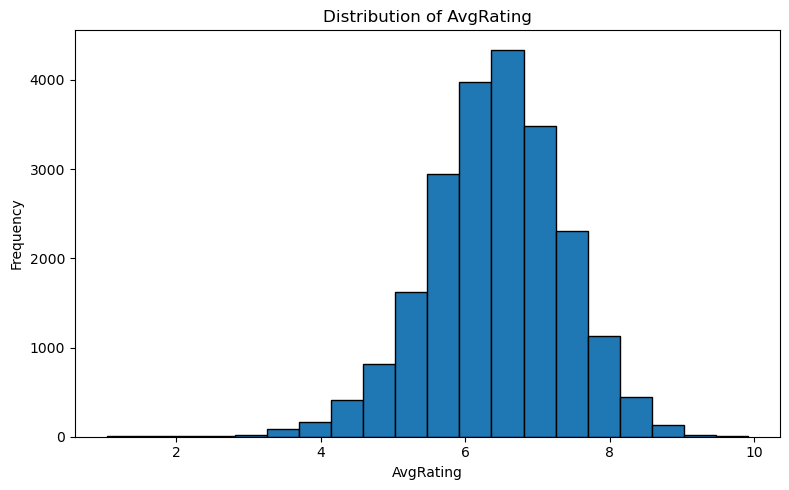

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(df["AvgRating"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of AvgRating")
plt.xlabel("AvgRating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

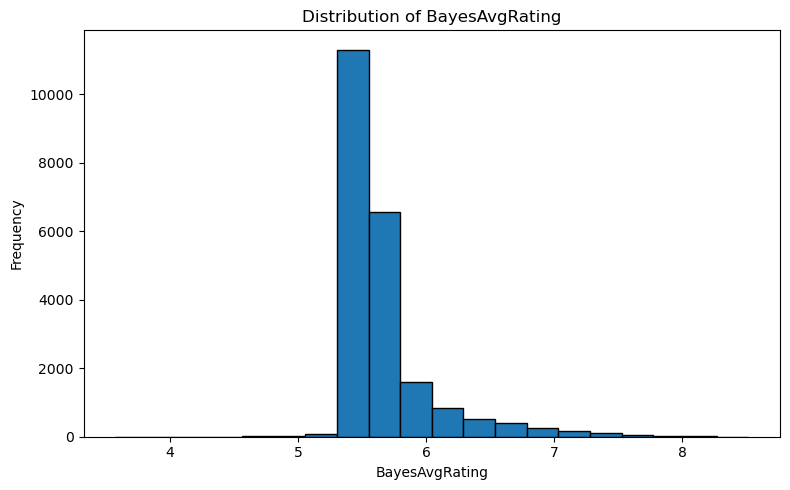

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(df["BayesAvgRating"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of BayesAvgRating")
plt.xlabel("BayesAvgRating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

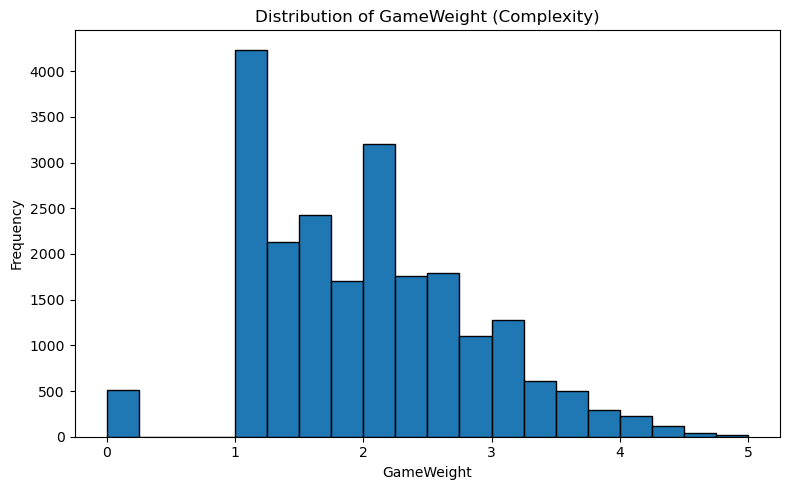

In [10]:
# game weight is basically game complexity
plt.figure(figsize=(8, 5))
plt.hist(df["GameWeight"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of GameWeight (Complexity)")
plt.xlabel("GameWeight")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

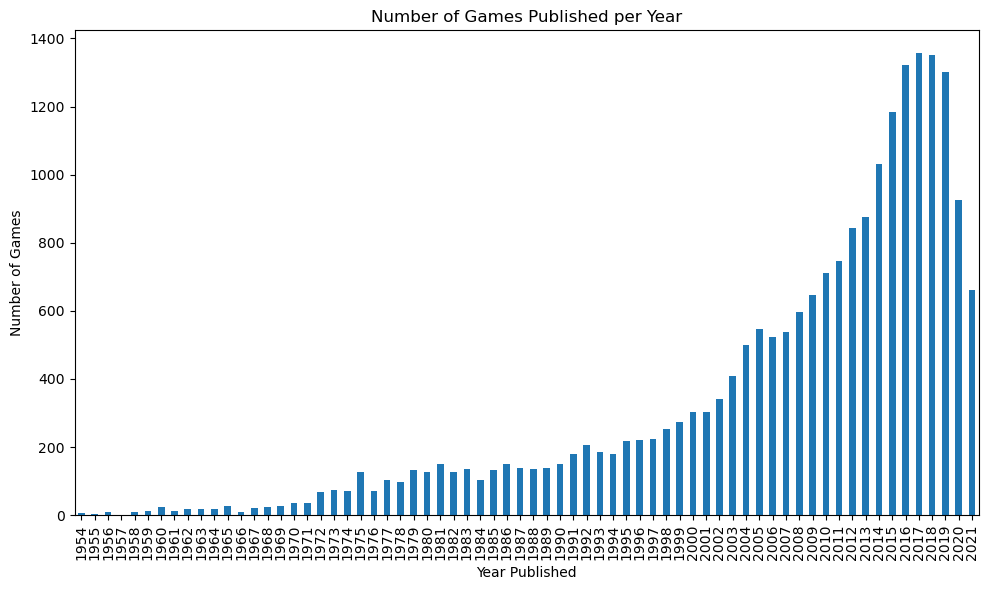

In [11]:
plt.figure(figsize=(10, 6))
year_counts = df['YearPublished'].dropna().value_counts().sort_index()[120:]
year_counts.plot(kind="bar")
plt.title("Number of Games Published per Year")
plt.xlabel("Year Published")
plt.ylabel("Number of Games")
plt.tight_layout()
plt.show()

# Relationships between Numerical Columns

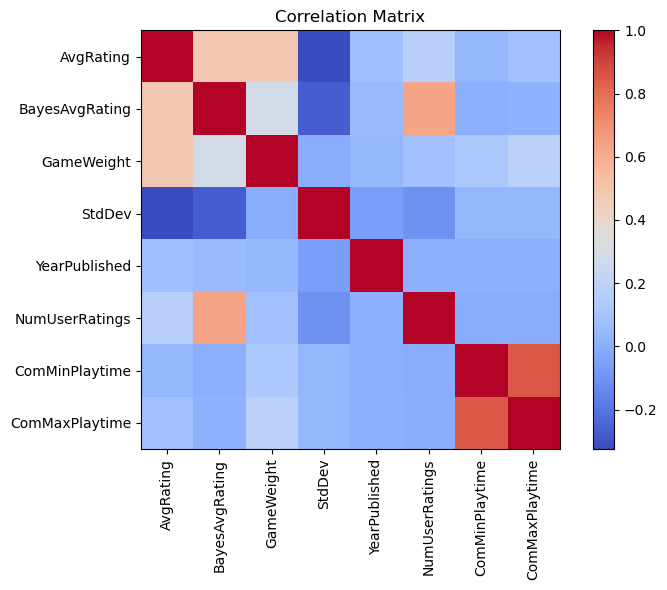

In [12]:
numeric_cols = [
    "AvgRating", "BayesAvgRating", "GameWeight", "StdDev",
    "YearPublished", "NumUserRatings", "ComMinPlaytime", "ComMaxPlaytime"
]
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap="coolwarm", interpolation="none")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Analysis of Binary Features

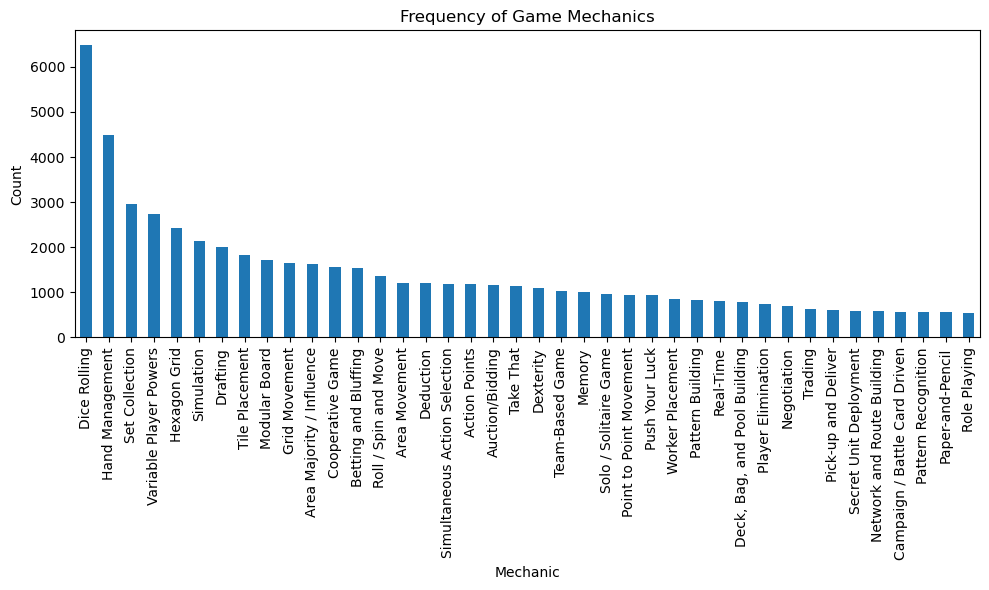

In [13]:
mechanics_cols = mechanics.columns.tolist()
if "BGGId" in mechanics_cols:
    mechanics_cols.remove("BGGId")
mechanics_counts = mechanics[mechanics_cols].sum().sort_values(ascending=False)[:40]

plt.figure(figsize=(10, 6))
mechanics_counts.plot(kind="bar")
plt.title("Frequency of Game Mechanics")
plt.xlabel("Mechanic")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

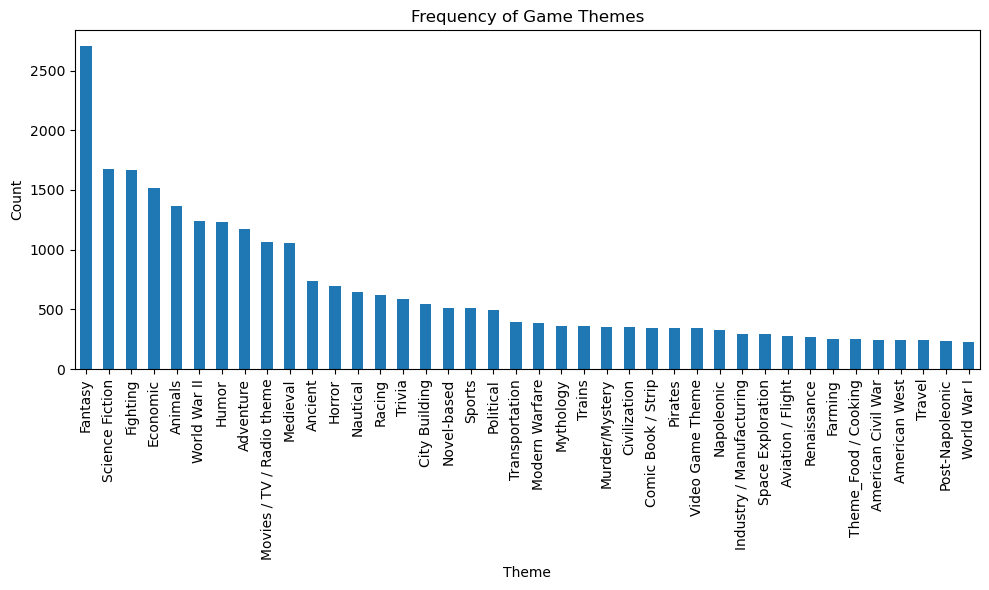

In [14]:
themes_cols = themes.columns.tolist()
if "BGGId" in themes_cols:
    themes_cols.remove("BGGId")
themes_counts = themes[themes_cols].sum().sort_values(ascending=False)[:40]

plt.figure(figsize=(10, 6))
themes_counts.plot(kind="bar")
plt.title("Frequency of Game Themes")
plt.xlabel("Theme")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Distribution of Ratings

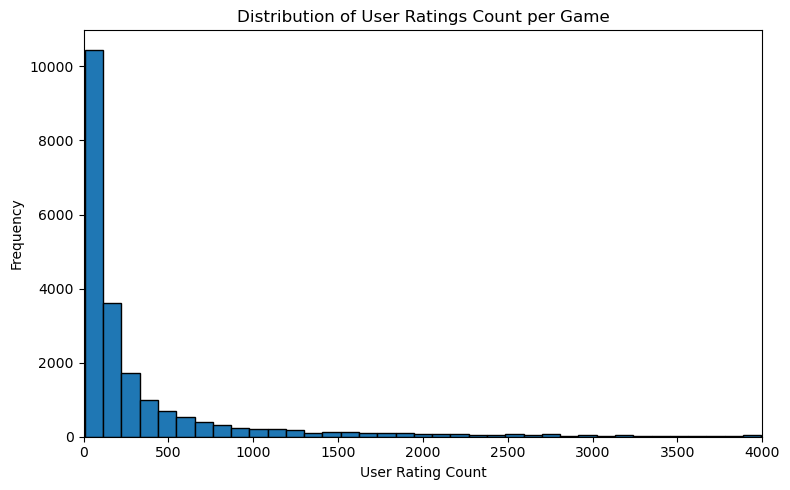

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(user_ratings_agg["user_rating_count"].dropna(), bins=1000, edgecolor="black")
plt.xlim(0, 4000)
plt.title("Distribution of User Ratings Count per Game")
plt.xlabel("User Rating Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Handle Description Column

In [16]:
# embeddings generated from sBERT in Google Colab (bc envr issues in Jupyter)
df = pd.concat([embeddings_df, df], axis=1)
df = df.drop('Description', axis=1)

# Normalize Numeric Columns

In [17]:
# remove ratings columns from the game data before saving overall data bc we have rating proportion columns now
old_rating_cols = ['0.0', '0.1', '0.5', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.0', '2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4.0', '4.1', '4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7.0', '7.1', '7.2', '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8.0', '8.1', '8.2', '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9.0', '9.1', '9.2', '9.3', '9.4', '9.5', '9.6', '9.7', '9.8', '9.9', '10.0']
df = df.drop(columns=old_rating_cols)

# normalize numeric columns (make sure range of values is similar to avoid large range columns dominating training)
exclude_columns = ['BGGId', 'Name']
numeric_columns = [
    col for col in df.columns 
    if col not in exclude_columns and np.issubdtype(df[col].dtype, np.number)
]

scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Make Overall Games File

In [18]:
# lists of player ids
df = df.drop('BestPlayers', axis=1)
df = df.drop('GoodPlayers', axis=1)
# 0 for all games
df = df.drop('NumComments', axis=1)

df.to_csv('../../bgg_data/overall_games.csv', index=False)

In [19]:
#overall = pd.read_csv("../../bgg_data/overall_games.csv")

In [20]:
#overall = overall.drop('BestPlayers', axis=1)
#overall = overall.drop('GoodPlayers', axis=1)

In [21]:
#print(overall.columns.tolist())

In [22]:
for col in df.columns:
    print(df[col].value_counts(), "\n-----------------")

0.392026    4
0.263236    4
0.702463    3
0.701682    3
0.342436    3
           ..
0.501510    1
0.356448    1
0.327336    1
0.438168    1
0.130344    1
Name: desc_emb_0, Length: 21898, dtype: int64 
-----------------
0.466289    4
0.561256    4
0.352041    3
0.339933    3
0.350287    3
           ..
0.632589    1
0.535695    1
0.644971    1
0.577946    1
0.573116    1
Name: desc_emb_1, Length: 21893, dtype: int64 
-----------------
0.375561    4
0.430942    4
0.601775    3
0.606247    3
0.611664    3
           ..
0.413781    1
0.361284    1
0.199095    1
0.362336    1
0.382280    1
Name: desc_emb_2, Length: 21898, dtype: int64 
-----------------
0.652032    4
0.701751    4
0.625550    3
0.618049    3
0.635295    3
           ..
0.401034    1
0.395243    1
0.287265    1
0.406426    1
0.503102    1
Name: desc_emb_3, Length: 21891, dtype: int64 
-----------------
0.516275    4
0.386168    4
0.536735    3
0.535983    3
0.564683    3
           ..
0.326281    1
0.511037    1
0.448510    

0.295560    4
0.432737    4
0.371072    3
0.377437    3
0.384540    3
           ..
0.286900    1
0.494018    1
0.384455    1
0.438879    1
0.473834    1
Name: desc_emb_111, Length: 21898, dtype: int64 
-----------------
0.274765    4
0.685595    4
0.587692    3
0.591558    3
0.627169    3
           ..
0.382353    1
0.324002    1
0.465702    1
0.619813    1
0.304068    1
Name: desc_emb_112, Length: 21894, dtype: int64 
-----------------
0.580486    4
0.493852    4
0.495889    3
0.538918    3
0.526096    3
           ..
0.459357    1
0.653875    1
0.569497    1
0.439278    1
0.737898    1
Name: desc_emb_113, Length: 21892, dtype: int64 
-----------------
0.545969    4
0.845043    4
0.687509    3
0.683310    3
0.684084    3
           ..
0.398361    1
0.439367    1
0.569720    1
0.757551    1
0.524678    1
Name: desc_emb_114, Length: 21895, dtype: int64 
-----------------
0.683104    4
0.539955    4
0.476831    3
0.481955    3
0.489771    3
           ..
0.720754    1
0.228476    1
0.44

0.778533    4
0.569916    4
0.665162    3
0.666166    3
0.667610    3
           ..
0.637419    1
0.324744    1
0.810724    1
0.567259    1
0.556398    1
Name: desc_emb_228, Length: 21892, dtype: int64 
-----------------
0.414395    4
0.702427    4
0.635241    3
0.639655    3
0.628966    3
           ..
0.641947    1
0.608263    1
0.347870    1
0.577502    1
0.504463    1
Name: desc_emb_229, Length: 21898, dtype: int64 
-----------------
0.382838    4
0.381024    4
0.251919    3
0.257854    3
0.261657    3
           ..
0.525814    1
0.461753    1
0.368864    1
0.482219    1
0.595463    1
Name: desc_emb_230, Length: 21897, dtype: int64 
-----------------
0.567715    4
0.473057    4
0.545693    3
0.549573    3
0.549472    3
           ..
0.440408    1
0.388407    1
0.422585    1
0.426046    1
0.296265    1
Name: desc_emb_231, Length: 21895, dtype: int64 
-----------------
0.503081    4
0.566104    4
0.732161    3
0.759919    3
0.728845    3
           ..
0.718019    1
0.412870    1
0.46

0.692212    4
0.635592    4
0.539160    3
0.529095    3
0.567094    3
           ..
0.476411    1
0.739756    1
0.295832    1
0.497314    1
0.418000    1
Name: desc_emb_349, Length: 21891, dtype: int64 
-----------------
0.671819    4
0.522516    4
0.539612    3
0.525557    3
0.532858    3
           ..
0.681690    1
0.563406    1
0.669007    1
0.558233    1
0.463388    1
Name: desc_emb_350, Length: 21896, dtype: int64 
-----------------
0.527621    4
0.357638    4
0.502747    3
0.515220    3
0.539195    3
           ..
0.604978    1
0.348159    1
0.431302    1
0.491552    1
0.312022    1
Name: desc_emb_351, Length: 21900, dtype: int64 
-----------------
0.510782    4
0.499167    4
0.589283    3
0.571642    3
0.592487    3
           ..
0.436567    1
0.749496    1
0.275298    1
0.275223    1
0.484888    1
Name: desc_emb_352, Length: 21901, dtype: int64 
-----------------
0.503085    4
0.445114    4
0.599128    3
0.599032    3
0.573140    3
           ..
0.449256    1
0.427391    1
0.48

0.0    21918
1.0        6
Name: Fantasy Shop, dtype: int64 
-----------------
0.0    21882
1.0       42
Name: Morapiaf, dtype: int64 
-----------------
0.0    21882
1.0       42
Name: Oliphante, dtype: int64 
-----------------
0.0    21916
1.0        8
Name: Barnes & Noble, dtype: int64 
-----------------
0.0    21875
1.0       49
Name: Carlit, dtype: int64 
-----------------
0.0    21900
1.0       24
Name: El Greco, dtype: int64 
-----------------
0.0    21919
1.0        5
Name: Guau, dtype: int64 
-----------------
0.0    21911
1.0       13
Name: Juegos Crone, dtype: int64 
-----------------
0.0    21888
1.0       36
Name: Nilco S.A., dtype: int64 
-----------------
0.0    21917
1.0        7
Name: Smeets & Schippers, dtype: int64 
-----------------
0.0    21899
1.0       25
Name: Tomy, dtype: int64 
-----------------
0.0    21877
1.0       47
Name: Kanga Games, dtype: int64 
-----------------
0.0    21854
1.0       70
Name: Nasza Księgarnia, dtype: int64 
-----------------
0.0    219

In [23]:
df["Kickstarted"].value_counts()

0.0    18562
1.0     3362
Name: Kickstarted, dtype: int64

In [24]:
print(df.columns.tolist())

['desc_emb_0', 'desc_emb_1', 'desc_emb_2', 'desc_emb_3', 'desc_emb_4', 'desc_emb_5', 'desc_emb_6', 'desc_emb_7', 'desc_emb_8', 'desc_emb_9', 'desc_emb_10', 'desc_emb_11', 'desc_emb_12', 'desc_emb_13', 'desc_emb_14', 'desc_emb_15', 'desc_emb_16', 'desc_emb_17', 'desc_emb_18', 'desc_emb_19', 'desc_emb_20', 'desc_emb_21', 'desc_emb_22', 'desc_emb_23', 'desc_emb_24', 'desc_emb_25', 'desc_emb_26', 'desc_emb_27', 'desc_emb_28', 'desc_emb_29', 'desc_emb_30', 'desc_emb_31', 'desc_emb_32', 'desc_emb_33', 'desc_emb_34', 'desc_emb_35', 'desc_emb_36', 'desc_emb_37', 'desc_emb_38', 'desc_emb_39', 'desc_emb_40', 'desc_emb_41', 'desc_emb_42', 'desc_emb_43', 'desc_emb_44', 'desc_emb_45', 'desc_emb_46', 'desc_emb_47', 'desc_emb_48', 'desc_emb_49', 'desc_emb_50', 'desc_emb_51', 'desc_emb_52', 'desc_emb_53', 'desc_emb_54', 'desc_emb_55', 'desc_emb_56', 'desc_emb_57', 'desc_emb_58', 'desc_emb_59', 'desc_emb_60', 'desc_emb_61', 'desc_emb_62', 'desc_emb_63', 'desc_emb_64', 'desc_emb_65', 'desc_emb_66', 'des

In [25]:
print(df.columns.tolist().index("Cat:Thematic"))

514


In [26]:
df.isna().sum()

desc_emb_0                1
desc_emb_1                1
desc_emb_2                1
desc_emb_3                1
desc_emb_4                1
                         ..
Origame                   1
Deep Print Games          1
Hidden Industries GmbH    1
Low-Exp Publisher         1
total_ratings             1
Length: 4365, dtype: int64

In [2]:
data = pd.read_csv("../../bgg_data/overall_games.csv")

In [28]:
df_filtered = data.groupby('Username').filter(lambda group: len(group) > 1000)


In [29]:
len(df_filtered)

993075

In [30]:
len(np.unique(df_filtered["Username"]))

695

In [31]:
df_filtered.to_csv('../../bgg_data/ratings_filtered.csv', index=False)

In [32]:
df_filtered.columns

Index(['BGGId', 'Rating', 'Username'], dtype='object')

In [37]:
data = pd.read_csv("../../bgg_data/overall_games.csv")
data.iloc[:10000, :].to_csv('../../bgg_data/overall_games_medium.csv', index=False)

In [34]:
data = pd.read_csv("../../bgg_data/overall_games_mini.csv")


In [35]:
data.isna().sum()

BGGId       0
Rating      0
Username    0
dtype: int64

In [2]:
games = pd.read_csv("../../bgg_data/overall_games.csv")
ratings = pd.read_csv("../../bgg_data/user_ratings.csv")
print(len(games))

21925


In [7]:
df_filtered = ratings.groupby('BGGId').filter(lambda group: 400 > len(group) > 300)
games_filtered = games[games["BGGId"].isin(df_filtered["BGGId"])]
print(len(df_filtered))
print(len(games_filtered))

351266
998


In [8]:
games_filtered.to_csv('../../bgg_data/overall_games_starter.csv', index=False)
df_filtered.to_csv('../../bgg_data/ratings_starter.csv', index=False)

In [4]:
data = pd.read_csv('../../bgg_data/ratings_starter.csv')


In [6]:
data["Username"].mode()[0]

'leffe dubbel'